<a href="https://colab.research.google.com/github/techn-0/Digital_Imaging/blob/main/scale_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 확대/축소 증강 (Scale Augmentation) 프로젝트
## Albumentations + OpenCV를 활용한 스케일 변환

**목표**: 원본 이미지를 1000장으로 확대/축소 증강
- 증강 방법: 스케일 변환 (Scale Transformation)
- 증강 단계: 1000단계의 스케일 레벨

**사용 라이브러리**:
- Albumentations: 고성능 이미지 증강
- OpenCV: 기본 이미지 처리 및 알고리즘 원리

## 1. 라이브러리 설치 및 임포트

In [1]:
# 필요한 라이브러리 설치
!pip install albumentations opencv-python-headless matplotlib numpy pillow

In [2]:
import albumentations as A
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from google.colab import files
from PIL import Image
import zipfile
from tqdm import tqdm

print(f"Albumentations 버전: {A.__version__}")
print(f"OpenCV 버전: {cv2.__version__}")

Albumentations 버전: 2.0.8
OpenCV 버전: 4.12.0


## 2. 디렉토리 설정 및 이미지 업로드

In [3]:
# 디렉토리 생성
os.makedirs('original_images', exist_ok=True)
os.makedirs('scale_augmented', exist_ok=True)
os.makedirs('scale_results', exist_ok=True)

print("디렉토리 생성 완료")
print("- original_images: 원본 이미지 저장")
print("- scale_augmented: 확대/축소 증강된 이미지 저장")
print("- scale_results: 분석 결과 저장")

디렉토리 생성 완료
- original_images: 원본 이미지 저장
- scale_augmented: 확대/축소 증강된 이미지 저장
- scale_results: 분석 결과 저장


In [4]:
# 이미지 업로드
print("원본 이미지를 업로드해주세요...")
uploaded = files.upload()

# 업로드된 파일을 original_images 폴더로 이동
for filename in uploaded.keys():
    os.rename(filename, f'original_images/{filename}')
    print(f"✓ {filename} 저장 완료")

# 원본 이미지 목록 확인
original_images = list(Path('original_images').glob('*'))
original_images = [str(img) for img in original_images if img.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']]

print(f"\n총 {len(original_images)}개의 원본 이미지가 준비되었습니다.")

원본 이미지를 업로드해주세요...


Saving 1000012973.jpg to 1000012973.jpg
Saving 1000012975.jpg to 1000012975.jpg
✓ 1000012973.jpg 저장 완료
✓ 1000012975.jpg 저장 완료

총 2개의 원본 이미지가 준비되었습니다.


## 3. 확대/축소 증강 파라미터 설정

### 목표: 1000장 생성
- 스케일 범위: 0.5 ~ 2.0 배율 (50% 축소 ~ 200% 확대)
- 증강 단계: 1000단계
- 간격: 0.0015씩 증가

In [5]:
# 확대/축소 증강 파라미터 정의
SCALE_FACTORS = np.linspace(0.5, 2.0, 1000)  # 1000단계
TARGET_COUNT = 1000

print(f"스케일 조정 단계: {len(SCALE_FACTORS)}개")
print(f"스케일 범위: {SCALE_FACTORS[0]:.2f} ~ {SCALE_FACTORS[-1]:.2f}")
print(f"스케일 간격: {SCALE_FACTORS[1] - SCALE_FACTORS[0]:.4f}")
print(f"\n총 생성될 이미지: {len(SCALE_FACTORS)}장")

# 샘플 스케일 값 출력
print(f"\n[샘플 스케일 값]")
print(f"  50% 축소: {SCALE_FACTORS[0]:.2f}")
print(f"  75% 크기: {SCALE_FACTORS[166]:.2f}")
print(f"  원본 크기: {SCALE_FACTORS[333]:.2f}")
print(f"  150% 확대: {SCALE_FACTORS[666]:.2f}")
print(f"  200% 확대: {SCALE_FACTORS[999]:.2f}")

스케일 조정 단계: 1000개
스케일 범위: 0.50 ~ 2.00
스케일 간격: 0.0015

총 생성될 이미지: 1000장

[샘플 스케일 값]
  50% 축소: 0.50
  75% 크기: 0.75
  원본 크기: 1.00
  150% 확대: 1.50
  200% 확대: 2.00


## 4. 확대/축소 변환 알고리즘

### 수학적 원리

스케일 변환은 이미지의 크기를 변경하는 기하학적 변환입니다:

$$x' = s \times x$$
$$y' = s \times y$$

여기서:
- $s$: 스케일 팩터 (0.5 ~ 2.0)
- $(x, y)$: 원본 좌표
- $(x', y')$: 변환된 좌표

### 구현 방법
1. **Albumentations**: RandomScale 또는 Affine 사용
2. **OpenCV**: resize 함수 사용

In [6]:
def augment_scale_albumentations(image, scale_factor):
    """
    Albumentations를 사용한 확대/축소 증강

    Args:
        image: 입력 이미지 (numpy array, RGB)
        scale_factor: 스케일 배율 (0.5~2.0)

    Returns:
        augmented_image: 크기가 조정된 이미지
    """
    original_height, original_width = image.shape[:2]

    # Albumentations Affine transform 사용
    transform = A.Compose([
        A.Affine(
            scale=scale_factor,  # 스케일 팩터
            translate_percent=None,
            rotate=0,
            shear=0,
            interpolation=cv2.INTER_LINEAR,
            cval=0,
            mode=cv2.BORDER_CONSTANT,
            fit_output=False,  # 원본 크기 유지
            p=1.0
        ),
    ])

    # 증강 적용
    augmented = transform(image=image)
    result = augmented['image']

    # 원본 크기로 맞추기 (crop 또는 pad)
    result_h, result_w = result.shape[:2]

    if result_h < original_height or result_w < original_width:
        # Padding 필요
        pad_h = max(0, original_height - result_h)
        pad_w = max(0, original_width - result_w)
        result = cv2.copyMakeBorder(
            result,
            pad_h // 2, pad_h - pad_h // 2,
            pad_w // 2, pad_w - pad_w // 2,
            cv2.BORDER_CONSTANT, value=0
        )

    if result_h > original_height or result_w > original_width:
        # Cropping 필요
        start_h = (result_h - original_height) // 2
        start_w = (result_w - original_width) // 2
        result = result[start_h:start_h+original_height, start_w:start_w+original_width]

    return result


def augment_scale_opencv(image, scale_factor):
    """
    OpenCV를 사용한 확대/축소 증강

    Args:
        image: 입력 이미지 (numpy array, RGB)
        scale_factor: 스케일 배율

    Returns:
        augmented_image: 크기가 조정된 이미지
    """
    original_height, original_width = image.shape[:2]

    # 새로운 크기 계산
    new_width = int(original_width * scale_factor)
    new_height = int(original_height * scale_factor)

    # OpenCV resize 사용
    # interpolation: INTER_LINEAR (확대/축소 모두 적합)
    scaled = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

    # 원본 크기로 맞추기
    if scale_factor < 1.0:
        # 축소된 경우 - 패딩 추가
        pad_h = original_height - new_height
        pad_w = original_width - new_width
        result = cv2.copyMakeBorder(
            scaled,
            pad_h // 2, pad_h - pad_h // 2,
            pad_w // 2, pad_w - pad_w // 2,
            cv2.BORDER_CONSTANT, value=0
        )
    else:
        # 확대된 경우 - 중앙 크롭
        start_h = (new_height - original_height) // 2
        start_w = (new_width - original_width) // 2
        result = scaled[start_h:start_h+original_height, start_w:start_w+original_width]

    return result

print("✓ 확대/축소 증강 함수 정의 완료")

✓ 확대/축소 증강 함수 정의 완료


## 5. 알고리즘 비교 및 샘플 생성

/tmp/ipython-input-1378469064.py:16: UserWarning: Argument(s) 'cval, mode' are not valid for transform Affine
  A.Affine(
/tmp/ipython-input-3305292601.py:35: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3305292601.py:35: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3305292601.py:35: UserWarning: Glyph 52629 (\N{HANGUL SYLLABLE CUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3305292601.py:35: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3305292601.py:35: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3305292601.py:35: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-33

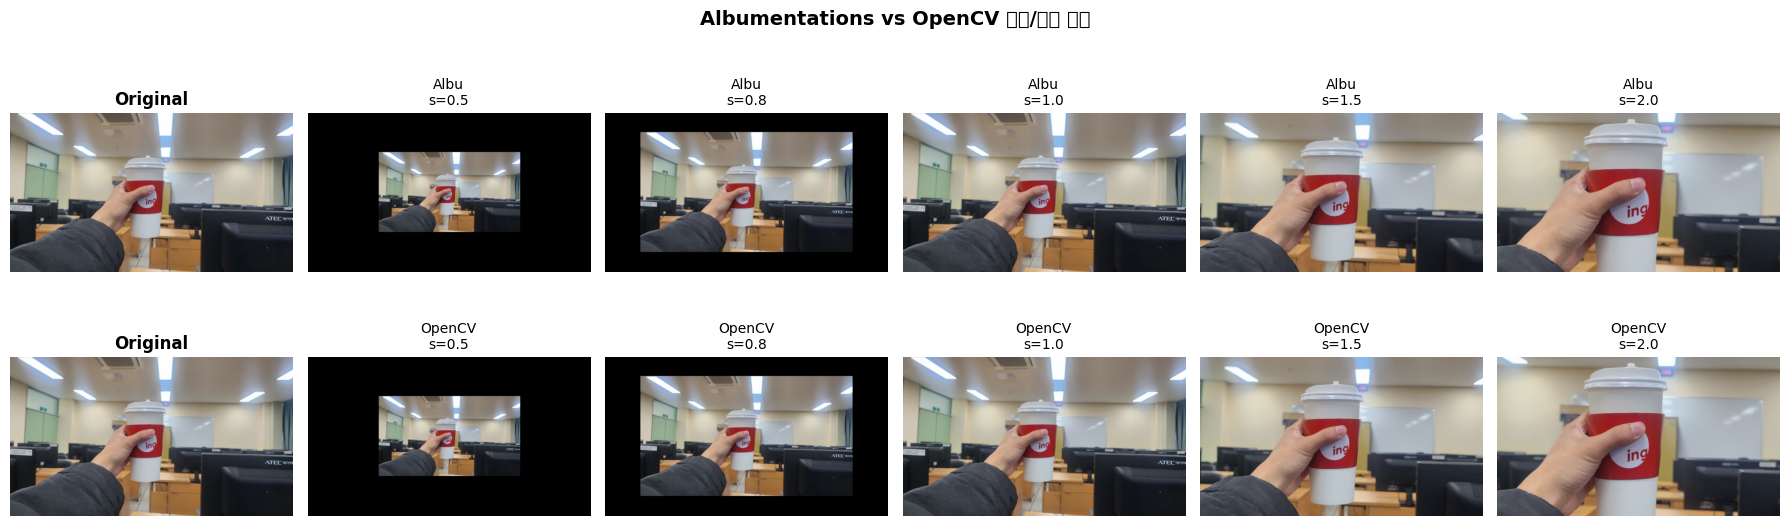

✓ 알고리즘 비교 이미지 저장: scale_results/algorithm_comparison.png


In [7]:
# 첫 번째 원본 이미지로 샘플 생성
if len(original_images) > 0:
    sample_image_path = original_images[0]
    sample_image = cv2.imread(sample_image_path)
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

    # 5가지 다른 스케일로 테스트
    test_scales = [0.5, 0.75, 1.0, 1.5, 2.0]

    fig, axes = plt.subplots(2, 6, figsize=(18, 6))

    # 첫 번째 행: Albumentations
    axes[0, 0].imshow(sample_image)
    axes[0, 0].set_title('Original', fontweight='bold')
    axes[0, 0].axis('off')

    for idx, scale in enumerate(test_scales, 1):
        aug_img = augment_scale_albumentations(sample_image, scale)
        axes[0, idx].imshow(aug_img)
        axes[0, idx].set_title(f'Albu\ns={scale:.1f}', fontsize=10)
        axes[0, idx].axis('off')

    # 두 번째 행: OpenCV
    axes[1, 0].imshow(sample_image)
    axes[1, 0].set_title('Original', fontweight='bold')
    axes[1, 0].axis('off')

    for idx, scale in enumerate(test_scales, 1):
        aug_img = augment_scale_opencv(sample_image, scale)
        axes[1, idx].imshow(aug_img)
        axes[1, idx].set_title(f'OpenCV\ns={scale:.1f}', fontsize=10)
        axes[1, idx].axis('off')

    plt.suptitle('Albumentations vs OpenCV 확대/축소 비교', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('scale_results/algorithm_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ 알고리즘 비교 이미지 저장: scale_results/algorithm_comparison.png")
else:
    print("⚠ 원본 이미지를 먼저 업로드해주세요.")

## 6. 스케일 단계별 샘플 시각화

/tmp/ipython-input-1378469064.py:16: UserWarning: Argument(s) 'cval, mode' are not valid for transform Affine
  A.Affine(
/tmp/ipython-input-3405140801.py:16: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3405140801.py:16: UserWarning: Glyph 52992 (\N{HANGUL SYLLABLE KE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3405140801.py:16: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3405140801.py:16: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3405140801.py:16: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3405140801.py:16: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3

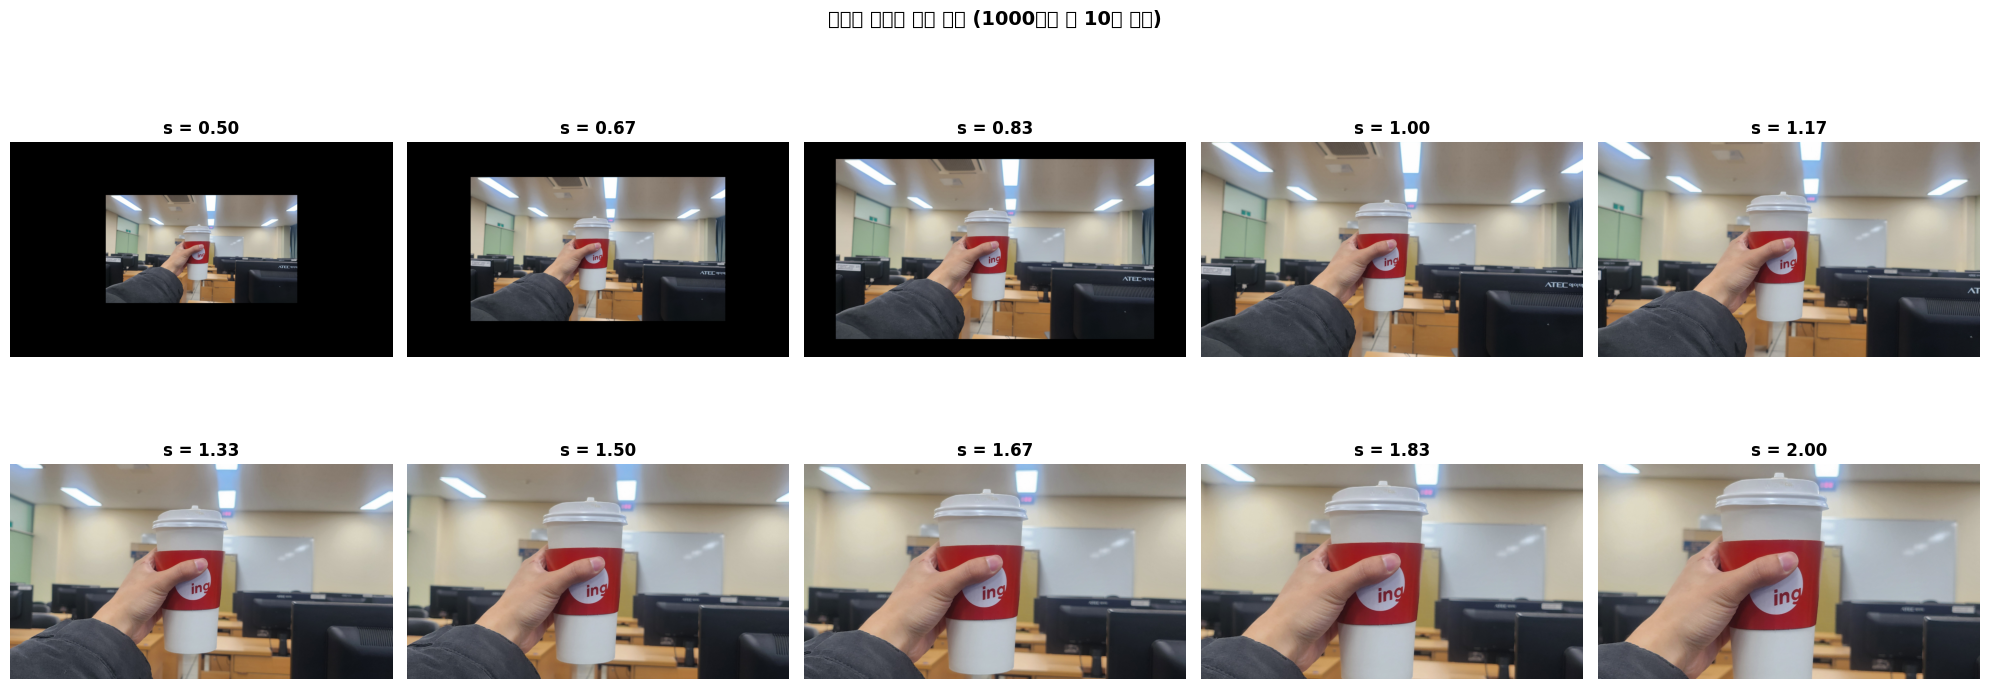

✓ 스케일 샘플 이미지 저장: scale_results/scale_samples.png


In [8]:
# 1000단계 중 대표적인 10단계 선택
if len(original_images) > 0:
    sample_indices = [0, 111, 222, 333, 444, 555, 666, 777, 888, 999]
    sample_scales = SCALE_FACTORS[sample_indices]

    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()

    for idx, scale in enumerate(sample_scales):
        aug_img = augment_scale_albumentations(sample_image, scale)
        axes[idx].imshow(aug_img)
        axes[idx].set_title(f's = {scale:.2f}', fontsize=12, fontweight='bold')
        axes[idx].axis('off')

    plt.suptitle('스케일 단계별 증강 결과 (1000단계 중 10개 샘플)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('scale_results/scale_samples.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ 스케일 샘플 이미지 저장: scale_results/scale_samples.png")

## 7. 전체 이미지 확대/축소 증강 수행 (1000장 생성)

In [9]:
def perform_scale_augmentation(image_paths, output_dir, method='albumentations'):
    """
    전체 이미지 확대/축소 증강 수행

    Args:
        image_paths: 원본 이미지 경로 리스트
        output_dir: 출력 디렉토리
        method: 'albumentations' 또는 'opencv'
    """
    augment_func = augment_scale_albumentations if method == 'albumentations' else augment_scale_opencv

    total_augmentations = 0
    images_per_original = len(SCALE_FACTORS)

    print(f"\n{'='*70}")
    print(f"확대/축소 증강 시작: {method.upper()} 방식")
    print(f"원본 이미지: {len(image_paths)}개")
    print(f"이미지당 생성 개수: {images_per_original}개")
    print(f"예상 총 생성 개수: {len(image_paths) * images_per_original}개")
    print(f"{'='*70}\n")

    for img_idx, img_path in enumerate(image_paths):
        # 이미지 로드
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        img_name = Path(img_path).stem

        print(f"[{img_idx+1}/{len(image_paths)}] 처리 중: {img_name}")

        # 모든 스케일에 대해 증강
        with tqdm(total=images_per_original, desc=f"  스케일 증강 진행") as pbar:
            for scale_idx, scale in enumerate(SCALE_FACTORS):
                # 증강 수행
                augmented = augment_func(image, scale)

                # 파일명 생성
                output_filename = f"{img_name}_scale_{scale_idx:04d}_factor{scale:.3f}.jpg"
                output_path = os.path.join(output_dir, output_filename)

                # 저장 (RGB -> BGR 변환)
                cv2.imwrite(output_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))

                total_augmentations += 1
                pbar.update(1)

        print(f"  ✓ {img_name}: {images_per_original}개 생성 완료\n")

    print(f"\n{'='*70}")
    print(f"확대/축소 증강 완료!")
    print(f"총 생성된 이미지: {total_augmentations}개")
    print(f"저장 위치: {output_dir}")
    print(f"{'='*70}\n")

    return total_augmentations

In [10]:
# Albumentations로 확대/축소 증강 수행
total_count = perform_scale_augmentation(
    original_images,
    'scale_augmented',
    method='albumentations'
)


확대/축소 증강 시작: ALBUMENTATIONS 방식
원본 이미지: 2개
이미지당 생성 개수: 1000개
예상 총 생성 개수: 2000개

[1/2] 처리 중: 1000012973


  스케일 증강 진행:   0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipython-input-1378469064.py:16: UserWarning: Argument(s) 'cval, mode' are not valid for transform Affine
  A.Affine(
  스케일 증강 진행: 100%|██████████| 1000/1000 [02:11<00:00,  7.60it/s]


  ✓ 1000012973: 1000개 생성 완료

[2/2] 처리 중: 1000012975


  스케일 증강 진행: 100%|██████████| 1000/1000 [02:16<00:00,  7.34it/s]

  ✓ 1000012975: 1000개 생성 완료


확대/축소 증강 완료!
총 생성된 이미지: 2000개
저장 위치: scale_augmented



## 8. 증강 결과 분석 및 통계

총 증강된 이미지 개수: 2000개
목표 달성: ✓ 성공


/tmp/ipython-input-3436124395.py:36: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3436124395.py:36: UserWarning: Glyph 52992 (\N{HANGUL SYLLABLE KE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3436124395.py:36: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3436124395.py:36: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3436124395.py:36: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3436124395.py:36: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3436124395.py:36: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp

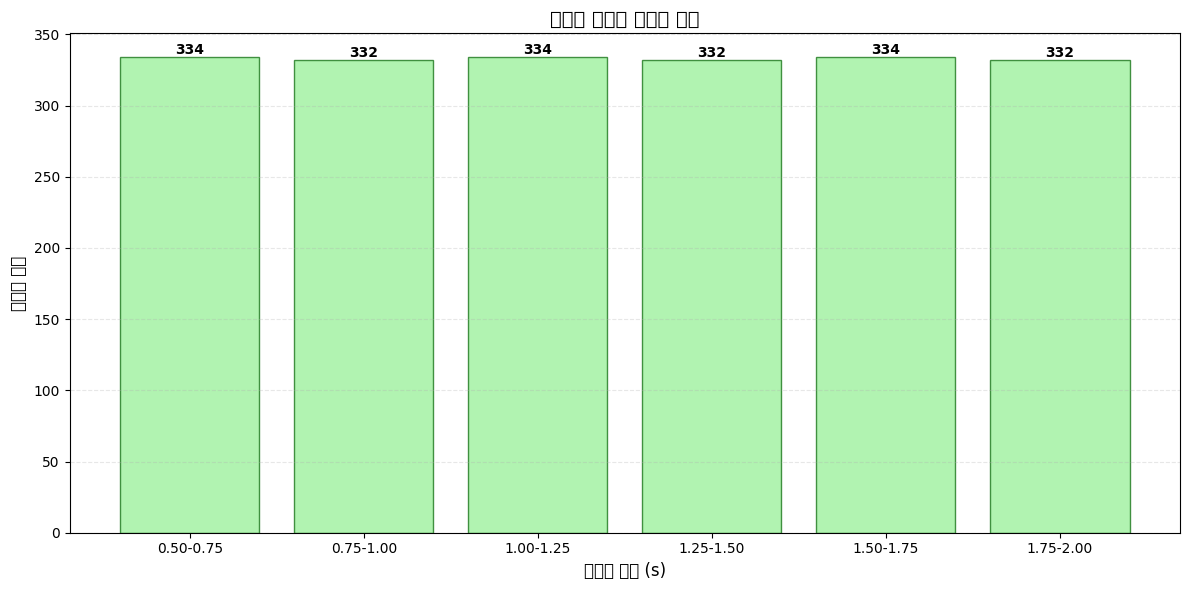

✓ 스케일 분포 그래프 저장: scale_results/scale_distribution.png


In [11]:
# 생성된 이미지 개수 확인
augmented_files = list(Path('scale_augmented').glob('*.jpg'))
print(f"총 증강된 이미지 개수: {len(augmented_files)}개")
print(f"목표 달성: {'✓ 성공' if len(augmented_files) >= 1000 else '✗ 미달성'}")

# 스케일 분포 분석
scale_distribution = np.zeros(6)  # 6개 구간
bins = [0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]

for file in augmented_files:
    filename = file.stem
    if 'factor' in filename:
        factor_str = filename.split('factor')[1]
        factor_value = float(factor_str)
        for i in range(len(bins)-1):
            if bins[i] <= factor_value < bins[i+1]:
                scale_distribution[i] += 1
                break

# 분포 시각화
fig, ax = plt.subplots(figsize=(12, 6))

bin_labels = [f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(len(bins)-1)]
bars = ax.bar(bin_labels, scale_distribution, color='lightgreen', edgecolor='darkgreen', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_title('스케일 레벨별 이미지 분포', fontsize=14, fontweight='bold')
ax.set_xlabel('스케일 배율 (s)', fontsize=12)
ax.set_ylabel('이미지 개수', fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('scale_results/scale_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ 스케일 분포 그래프 저장: scale_results/scale_distribution.png")

## 9. 랜덤 샘플 시각화

/tmp/ipython-input-363780142.py:26: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-363780142.py:26: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-363780142.py:26: UserWarning: Glyph 52629 (\N{HANGUL SYLLABLE CUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-363780142.py:26: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-363780142.py:26: UserWarning: Glyph 51613 (\N{HANGUL SYLLABLE JEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-363780142.py:26: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-363780142.py:26: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/t

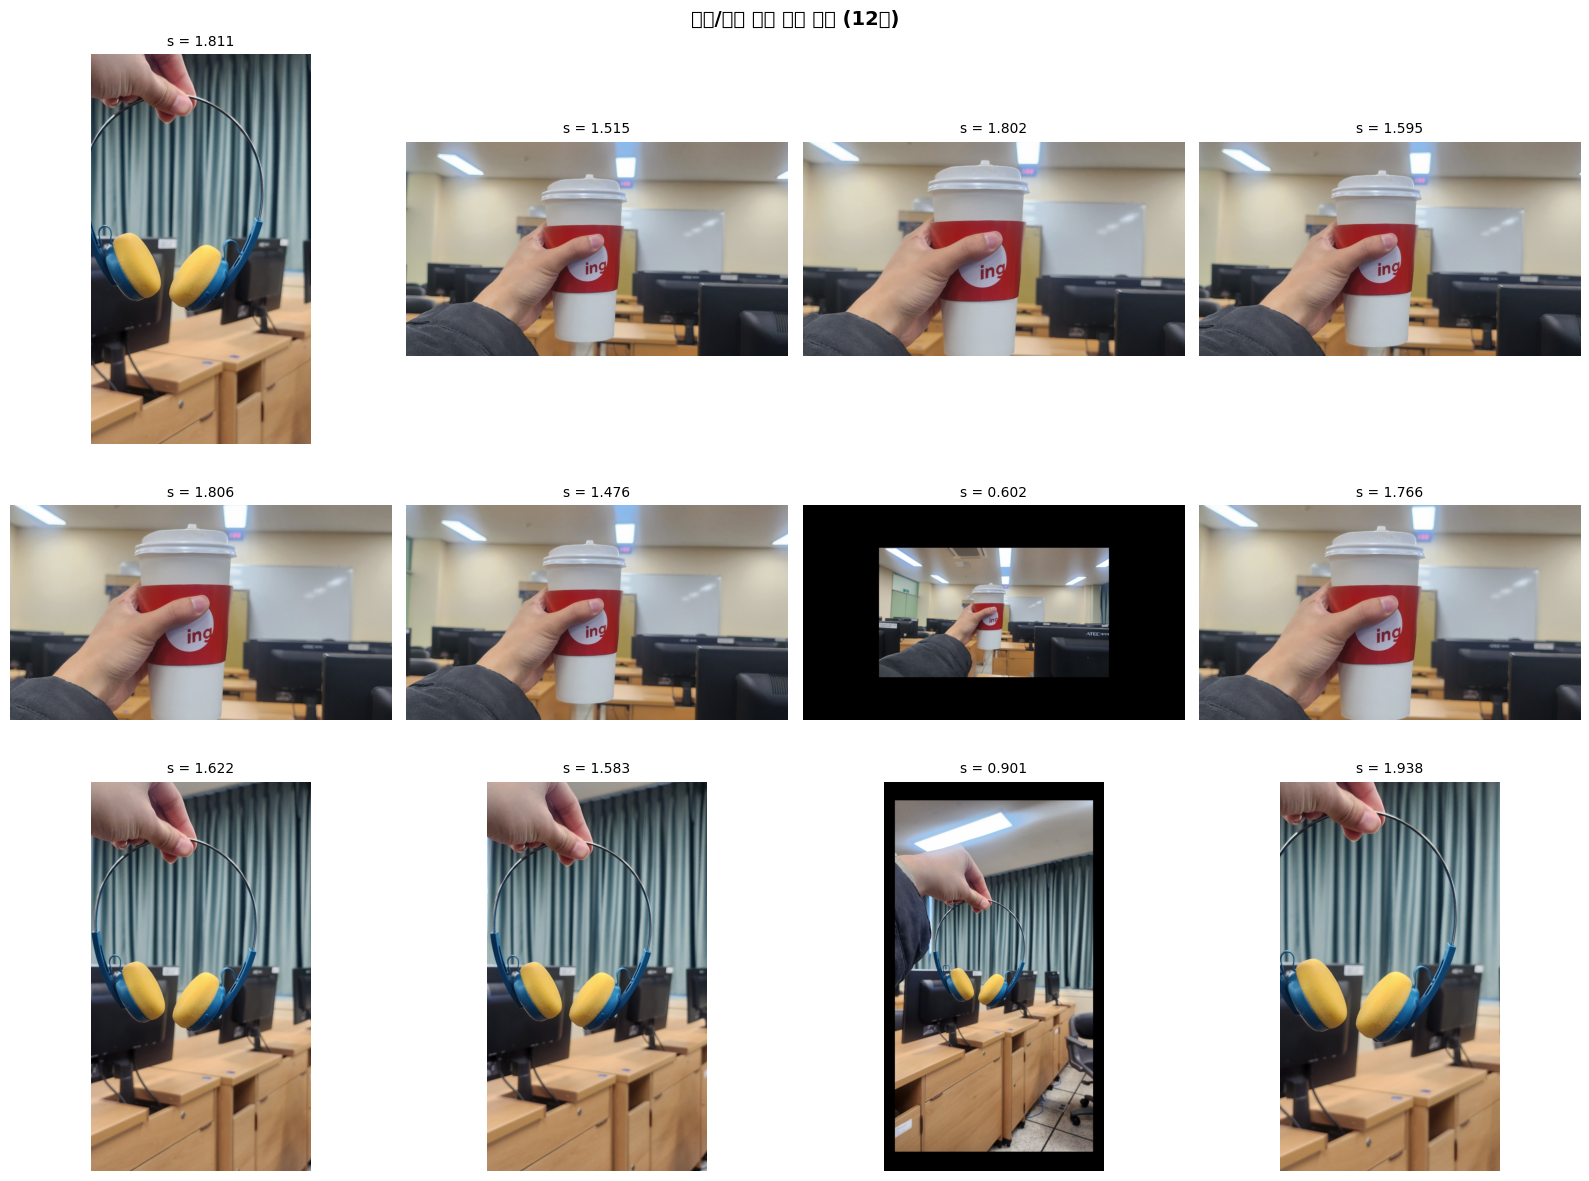

✓ 랜덤 샘플 이미지 저장: scale_results/random_samples.png


In [12]:
# 랜덤 샘플 시각화
if len(augmented_files) > 0:
    import random
    sample_files = random.sample(augmented_files, min(12, len(augmented_files)))

    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()

    for idx, img_path in enumerate(sample_files):
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        filename = img_path.stem
        if 'factor' in filename:
            factor_str = filename.split('factor')[1]
            factor_value = float(factor_str)
            title = f's = {factor_value:.3f}'
        else:
            title = img_path.name

        axes[idx].imshow(img)
        axes[idx].set_title(title, fontsize=10)
        axes[idx].axis('off')

    plt.suptitle('확대/축소 증강 랜덤 샘플 (12개)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('scale_results/random_samples.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ 랜덤 샘플 이미지 저장: scale_results/random_samples.png")

## 10. 결과 다운로드

In [13]:
# 증강된 이미지를 ZIP 파일로 압축
zip_filename = 'scale_augmented_images.zip'

print("ZIP 파일 생성 중...")
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for file in tqdm(augmented_files, desc="압축 진행"):
        zipf.write(file, file.name)

print(f"\n✓ ZIP 파일 생성 완료: {zip_filename}")
print(f"파일 크기: {os.path.getsize(zip_filename) / (1024*1024):.2f} MB")

# 다운로드
files.download(zip_filename)
print("\n다운로드가 시작되었습니다!")

ZIP 파일 생성 중...


압축 진행: 100%|██████████| 2000/2000 [02:27<00:00, 13.55it/s]


✓ ZIP 파일 생성 완료: scale_augmented_images.zip
파일 크기: 2793.42 MB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


다운로드가 시작되었습니다!
